In [2]:
import torch
import torch.nn as nn
from einops import rearrange, reduce, repeat
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array (1, 3, h, w) or (3, h, w) into a numpy image array."""
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        # convert it into a numpy array
        if image_tensor.dim() == 4:
            image_numpy = image_tensor[0].cpu().float().numpy()
        else:
            image_numpy = image_tensor.cpu().float().numpy()
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        # post-processing: tranpose and scaling
        # image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
        if image_numpy.shape[2] != 3:
            image_numpy = np.transpose(image_numpy, (1, 2, 0))
        image_numpy = np.clip(image_numpy * 255.0, 0, 255)
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

def show_tensor_imgs(tensors, rows=1, cols=1, size=4):
    """show a batch of images"""
    _, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    axes = axes.reshape(-1)
    for i in range(rows * cols):
        axes[i].imshow(tensor2im(tensors[i]))
        axes[i].set_axis_off()
    plt.show()

In [4]:
img = cv.imread('data/content-images/golden_gate.jpg')
img = cv.resize(img, (224, 224))
img = img[:, :, ::-1] / 255.0
img = torch.from_numpy(img).float()
img0 = cv.imread('data/content-images/taj_mahal.jpg')
img0 = cv.resize(img0, (224, 224))
img0 = img0[:, :, ::-1] / 255.0
img0 = torch.from_numpy(img0).float()
img.shape, img0.shape

(torch.Size([224, 224, 3]), torch.Size([224, 224, 3]))

In [5]:
img = img.permute(2, 0, 1)
img0 = img0.permute(2, 0, 1)

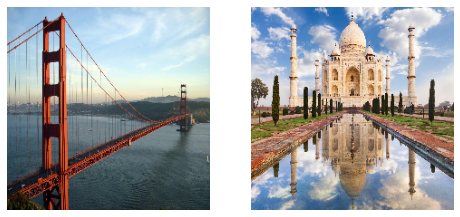

In [6]:
show_tensor_imgs(torch.stack([img, img0]), rows=1, cols=2)

## Einops

### img to vector

In [7]:
img1 = rearrange(img, 'c h w -> (c h w)')
img1.shape

torch.Size([150528])

### img to patches

In [8]:
img_patches = rearrange(img, 'c (p1 h) (p2 w) -> (p1 p2) c h w', p1=2, p2=2)
img_patches.shape

torch.Size([4, 3, 112, 112])

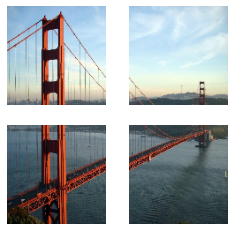

In [9]:
show_tensor_imgs(img_patches, rows=2, cols=2, size=2)

### mix image

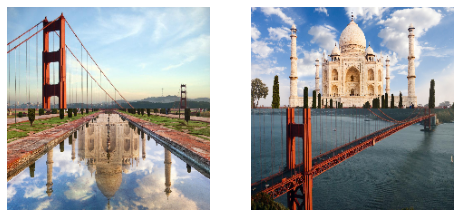

In [10]:
imgs = torch.stack([img, img0])
imgs = rearrange(imgs, 'b c (k h) w -> k b c h w', k=2)
mix1 = torch.cat([imgs[0, 0], imgs[1, 1]], dim=1)
mix2 = torch.cat([imgs[0, 1], imgs[1, 0]], dim=1)
show_tensor_imgs(torch.stack([mix1, mix2]), rows=1, cols=2)

### RGB to GrayScale

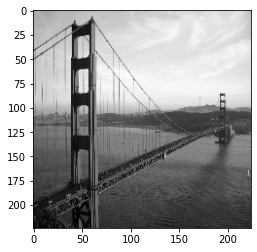

In [11]:
img_gray = reduce(img, 'c h w -> h w', reduction='mean')
plt.imshow(img_gray, cmap='gray')

### Upsize and Downsize

In [12]:
img_x2 = repeat(img, 'c h w -> c (h 2) (w 2)')
img_x2.shape

torch.Size([3, 448, 448])

torch.Size([3, 112, 112])


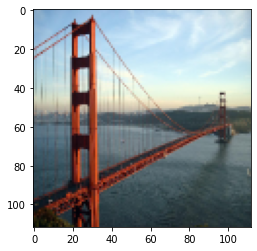

In [13]:
img_half = reduce(img, 'c (h 2) (w 2) -> c h w', reduction='mean')
print(img_half.shape)
assert img_half.shape == torch.Size([3, 112, 112]), 'wdf'
plt.imshow(img_half.permute(1,2,0))

## Einsum

In [14]:
x = torch.rand(2, 3)

In [15]:
# permute
torch.einsum('ij->ji', x).shape

torch.Size([3, 2])

In [16]:
# sum
torch.einsum('ij->', x)

tensor(4.4387)

In [17]:
# colum sum
torch.einsum('ij->j', x)

tensor([1.5212, 1.4431, 1.4744])

In [18]:
# raw sum
torch.einsum('ij->i', x)

tensor([1.9030, 2.5356])

In [19]:
v = torch.rand(1, 3)

In [21]:
# Ax
torch.einsum('ik,jk->ij', x, v).shape

torch.Size([2, 1])

In [23]:
# AB
torch.einsum('ij, kj->ik', x, x).shape

torch.Size([2, 2])

In [24]:
# dot product first row with first row of matrix
torch.einsum('i, i->', x[0], x[0])

tensor(1.3039)

In [25]:
# element-wise product
torch.einsum('ij,ij->ij', x, x).shape

torch.Size([2, 3])

In [28]:
# outer product
a = torch.rand(3)
b = torch.rand(5)
torch.einsum('i,j->ij', a, b).shape

torch.Size([3, 5])

In [29]:
# bmm
x = torch.rand(3, 4, 5)
y = torch.rand(3, 5, 2)
torch.einsum('ijk,ikl->ijl', x, y).shape

torch.Size([3, 4, 2])

In [31]:
# matrix diagnal
x = torch.rand(3, 3)
print(x)
torch.einsum('ii->i', x)

tensor([[0.6744, 0.1930, 0.4483],
        [0.6744, 0.1209, 0.0535],
        [0.2853, 0.1870, 0.4659]])


tensor([0.6744, 0.1209, 0.4659])

In [32]:
# matrix trace
torch.einsum('ii->', x)

tensor(1.2613)